In [67]:
# Cell 1: Load & merge NHANES cycles (2011, 2013, 2015, 2017)

import os
import numpy as np
import pandas as pd
import requests
import pyreadstat

# -----------------------------
# 1. Cache directory
# -----------------------------
CACHE_DIR = "nhanes_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

# -----------------------------
# 2. Loader with caching
# -----------------------------
def load_nhanes_xpt(filename: str, year: str) -> pd.DataFrame | None:
    local_path = os.path.join(CACHE_DIR, f"{year}_{filename}")

    # Use cached file
    if os.path.exists(local_path):
        print(f"Using cached: {local_path}")
        df, meta = pyreadstat.read_xport(local_path)
        return df

    # Download from CDC
    url = f"https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/{year}/DataFiles/{filename}"
    print(f"Downloading {url} ...")

    r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
    if r.status_code == 404:
        print(f"⚠ File NOT FOUND on server: {filename} for {year}")
        return None

    r.raise_for_status()
    with open(local_path, "wb") as f:
        f.write(r.content)

    df, meta = pyreadstat.read_xport(local_path)
    return df


# -----------------------------
# 3. Per-cycle file lists INCLUDING BMI, ALT, AST, CRP, CBC
# -----------------------------
nhanes_files_2011 = {
    "DEMO":   "DEMO_G.xpt",
    "HDL":    "HDL_G.xpt",
    "TCHOL":  "TCHOL_G.xpt",
    "TRIGLY": "TRIGLY_G.xpt",
    "GLU":    "GLU_G.xpt",
    "DPQ":    "DPQ_G.xpt",
    "SLQ":    "SLQ_G.xpt",
    "DR1TOT": "DR1TOT_G.xpt",
    "PAQ":    "PAQ_G.xpt",
    "BPX":    "BPX_G.xpt",
    "BIOPRO": "BIOPRO_G.xpt",   # ALT, AST, CRP may be here
    "ALB_CR": "ALB_CR_G.xpt",
    "BMX":    "BMX_G.xpt",       # BMI & waist
    "CBC":    "CBC_G.xpt",       # hemoglobin, WBC, platelets
}

nhanes_files_2013 = {
    "DEMO":   "DEMO_H.xpt",
    "HDL":    "HDL_H.xpt",
    "TCHOL":  "TCHOL_H.xpt",
    "TRIGLY": "TRIGLY_H.xpt",
    "GLU":    "GLU_H.xpt",
    "INS":    "INS_H.xpt",
    "DPQ":    "DPQ_H.xpt",
    "SLQ":    "SLQ_H.xpt",
    "DR1TOT": "DR1TOT_H.xpt",
    "PAQ":    "PAQ_H.xpt",
    "BPX":    "BPX_H.xpt",
    "BIOPRO": "BIOPRO_H.xpt",
    "ALB_CR": "ALB_CR_H.xpt",
    "BMX":    "BMX_H.xpt",
    "CBC":    "CBC_H.xpt",
}

nhanes_files_2015 = {
    "DEMO":   "DEMO_I.xpt",
    "HDL":    "HDL_I.xpt",
    "TCHOL":  "TCHOL_I.xpt",
    "TRIGLY": "TRIGLY_I.xpt",
    "GLU":    "GLU_I.xpt",
    "INS":    "INS_I.xpt",
    "DPQ":    "DPQ_I.xpt",
    "SLQ":    "SLQ_I.xpt",
    "DR1TOT": "DR1TOT_I.xpt",
    "PAQ":    "PAQ_I.xpt",
    "BPX":    "BPX_I.xpt",
    "BIOPRO": "BIOPRO_I.xpt",
    "ALB_CR": "ALB_CR_I.xpt",
    "BMX":    "BMX_I.xpt",
    "CBC":    "CBC_I.xpt",
}

nhanes_files_2017 = {
    "DEMO":   "DEMO_J.xpt",
    "HDL":    "HDL_J.xpt",
    "TCHOL":  "TCHOL_J.xpt",
    "TRIGLY": "TRIGLY_J.xpt",
    "GLU":    "GLU_J.xpt",
    "INS":    "INS_J.xpt",
    "DPQ":    "DPQ_J.xpt",
    "SLQ":    "SLQ_J.xpt",
    "DR1TOT": "DR1TOT_J.xpt",
    "PAQ":    "PAQ_J.xpt",
    "BPX":    "BPX_J.xpt",
    "BIOPRO": "BIOPRO_J.xpt",
    "ALB_CR": "ALB_CR_J.xpt",
    "BMX":    "BMX_J.xpt",
    "CBC":    "CBC_J.xpt",
}

all_cycles = {
    "2011": nhanes_files_2011,
    "2013": nhanes_files_2013,
    "2015": nhanes_files_2015,
    "2017": nhanes_files_2017,
}


# -----------------------------
# 4. Per-cycle merge
# -----------------------------
def load_cycle(files: dict, cycle_year: str) -> pd.DataFrame | None:
    dfs = []

    for name, fname in files.items():
        print(f"Loading {fname} for {cycle_year} ...")
        d = load_nhanes_xpt(fname, cycle_year)

        if d is None:
            print(f"⚠ Skipping missing file: {fname}")
            continue

        dfs.append(d)

    if len(dfs) == 0:
        print(f"⚠ No usable files for cycle {cycle_year}")
        return None

    merged = dfs[0]
    for d in dfs[1:]:
        merged = merged.merge(d, on="SEQN", how="outer")

    merged["CYCLE"] = cycle_year
    return merged


# -----------------------------
# 5. Run merge
# -----------------------------
merged_cycles = []

for cycle_year, files in all_cycles.items():
    print("\n======================")
    print(f"   Loading cycle {cycle_year}")
    print("======================\n")

    df_c = load_cycle(files, cycle_year)
    if df_c is not None:
        merged_cycles.append(df_c)

df_all = pd.concat(merged_cycles, ignore_index=True)

print("\nFINAL MERGED SHAPE:", df_all.shape)

df_all.to_csv("nhanes_2011_2018_merged.csv", index=False)
print("Saved: nhanes_2011_2018_merged.csv")



   Loading cycle 2011

Loading DEMO_G.xpt for 2011 ...
Using cached: nhanes_cache/2011_DEMO_G.xpt
Loading HDL_G.xpt for 2011 ...
Using cached: nhanes_cache/2011_HDL_G.xpt
Loading TCHOL_G.xpt for 2011 ...
Using cached: nhanes_cache/2011_TCHOL_G.xpt
Loading TRIGLY_G.xpt for 2011 ...
Using cached: nhanes_cache/2011_TRIGLY_G.xpt
Loading GLU_G.xpt for 2011 ...
Using cached: nhanes_cache/2011_GLU_G.xpt
Loading DPQ_G.xpt for 2011 ...
Using cached: nhanes_cache/2011_DPQ_G.xpt
Loading SLQ_G.xpt for 2011 ...
Using cached: nhanes_cache/2011_SLQ_G.xpt
Loading DR1TOT_G.xpt for 2011 ...
Using cached: nhanes_cache/2011_DR1TOT_G.xpt
Loading PAQ_G.xpt for 2011 ...
Using cached: nhanes_cache/2011_PAQ_G.xpt
Loading BPX_G.xpt for 2011 ...
Using cached: nhanes_cache/2011_BPX_G.xpt
Loading BIOPRO_G.xpt for 2011 ...
Using cached: nhanes_cache/2011_BIOPRO_G.xpt
Loading ALB_CR_G.xpt for 2011 ...
Using cached: nhanes_cache/2011_ALB_CR_G.xpt
Loading BMX_G.xpt for 2011 ...
Loading CBC_G.xpt for 2011 ...

   Load

In [69]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import GraphicalLasso

# -------------------------------------------------------
# UPDATED SYSTEM → VARIABLE MAP
# (Your original + added high-coverage biomarkers)
# -------------------------------------------------------
physio_systems_ggm = {
    "Demographics": ["age", "pir"],

    "Lipids": ["hdl", "tc", "tg", "ldl", "apob_est"],

    "Metabolic": [
        "glucose", "insulin", "homa_ir",
        "bmi", "waist"
    ],

    "Blood_Pressure": ["sbp", "dbp", "pulse_pressure"],

    "Renal": ["creat_mg_dl", "egfr", "acr"],

    "Liver": ["alt", "ast"],

    "Inflammation": ["crp", "wbc"],

    "Hematologic": ["hemoglobin", "platelets"],

    "Sleep": ["sleep_hours", "sleep_trouble"],

    "Mental_Health": ["phq9"],

    "Physical_Activity": [
        "pa_vigorous_days", "pa_moderate_days",
        "pa_walk_days", "pa_index"
    ],

    "Diet": [
        "whole_grains", "refined_grains", "nuts_seeds", "legumes",
        "low_fat_dairy", "fish", "red_meat", "processed_meat",
        "other_fruit", "citrus_melons_berries", "dark_green_veg",
        "other_veg", "ssb", "fried_foods"
    ],
}

# -------------------------------------------------------
# FLATTEN AND FILTER BY MISSINGNESS ≥ 40%
# -------------------------------------------------------
all_vars = sum(physio_systems_ggm.values(), [])
all_vars = [v for v in all_vars if v in df_h.columns]

nonmissing_frac = df_h[all_vars].notna().mean()
vars_use = nonmissing_frac[nonmissing_frac >= 0.40].index.tolist()

print("Variables used in variable-level GGM:")
print(vars_use)

# -------------------------------------------------------
# 2. IMPUTE + STANDARDIZE
# -------------------------------------------------------
X = df_h[vars_use].to_numpy(float)

imputer = KNNImputer(n_neighbors=5)
X_imp = imputer.fit_transform(X)

scaler = StandardScaler()
X_std = scaler.fit_transform(X_imp)

# -------------------------------------------------------
# 3. FIT GRAPHICAL LASSO
# -------------------------------------------------------
ggm_model = GraphicalLasso(alpha=0.15, max_iter=200)
ggm_model.fit(X_std)

precision = ggm_model.precision_.copy()

# Partial correlations
diag = np.sqrt(np.diag(precision))
outer = np.outer(diag, diag)
partial_corr = -precision / outer
np.fill_diagonal(partial_corr, 0.0)

# -------------------------------------------------------
# 4. BUILD NETWORKX GRAPH
# -------------------------------------------------------
G_var = nx.Graph()

# System membership lookup
var_to_system = {}
for system, var_list in physio_systems_ggm.items():
    for v in var_list:
        if v in vars_use:
            var_to_system[v] = system

# Add nodes
for v in vars_use:
    G_var.add_node(v, system=var_to_system.get(v, "Other"))

# Add edges (threshold = 0.10)
edge_threshold = 0.10
for i, vi in enumerate(vars_use):
    for j in range(i + 1, len(vars_use)):
        vj = vars_use[j]
        w = partial_corr[i, j]
        if abs(w) >= edge_threshold:
            G_var.add_edge(vi, vj, weight=w)

print(f"Variable-level GGM: {G_var.number_of_nodes()} nodes, {G_var.number_of_edges()} edges")

# -------------------------------------------------------
# 5. CONSISTENT LAYOUT
# -------------------------------------------------------
pos_var = nx.spring_layout(G_var, seed=1, k=0.35)


Variables used in variable-level GGM:
['age', 'pir', 'hdl', 'tc', 'sbp', 'dbp', 'pulse_pressure', 'creat_mg_dl', 'egfr', 'acr', 'phq9', 'pa_vigorous_days', 'pa_moderate_days', 'pa_walk_days', 'pa_index']
Variable-level GGM: 15 nodes, 9 edges


In [70]:
# Cell 3: Apply harmonization pipeline → df_h

def prepare_nhanes(df_raw: pd.DataFrame) -> pd.DataFrame:
    """
    Full harmonization pipeline:
      demographics, BP, lipids, renal, metabolic,
      sleep, PHQ, physical activity, diet.
    """
    return (
        df_raw
        .pipe(harmonize_demographics)
        .pipe(harmonize_bp)
        .pipe(harmonize_lipids)
        .pipe(harmonize_renal)
        .pipe(harmonize_metabolic)
        .pipe(harmonize_sleep)
        .pipe(harmonize_phq)
        .pipe(harmonize_physical_activity_days)
        .pipe(harmonize_diet)
    )

df_h = prepare_nhanes(df_all)
print("Harmonized shape:", df_h.shape)
print("Example PA columns present:",
      [c for c in ["pa_vigorous_days", "pa_moderate_days", "pa_walk_days", "pa_index"]
       if c in df_h.columns])


Harmonized shape: (39156, 526)
Example PA columns present: ['pa_vigorous_days', 'pa_moderate_days', 'pa_walk_days', 'pa_index']


In [71]:
# Cell 4: System-level variable dictionary

physio_systems = {
    # CARDIOMETABOLIC ------------------------------------------
    "Lipids": [
        "hdl", "ldl", "tc", "tg", "apob_est"
    ],

    "Metabolic": [
        "glucose", "insulin", "homa_ir"
    ],

    "Blood_Pressure": [
        "sbp", "dbp", "pulse_pressure"
    ],

    "Renal": [
        "egfr", "acr", "creat_mg_dl"
    ],

    # DIET ------------------------------------------------------
    "Food_Groups_HEI": [
        "whole_grains", "refined_grains", "nuts_seeds", "legumes",
        "low_fat_dairy", "fish", "red_meat", "processed_meat",
        "dark_green_veg", "other_veg", "citrus_melons_berries",
        "other_fruit", "ssb", "fried_foods",
    ],

    "Diet_Quality_Indices": [
        "rpdqs", "rpdqs_norm"
    ],

    # LIFESTYLE -------------------------------------------------
    "Sleep": ["sleep_hours", "sleep_trouble"],
    "Mental_Health": ["phq9"],

    # PHYSICAL ACTIVITY -----------------------------------------
    "Physical_Activity": [
        "pa_vigorous_days",
        "pa_moderate_days",
        "pa_walk_days",
        "pa_index",
    ],

    # MACRONUTRIENTS --------------------------------------------
    "Macronutrients": [
        "DR1TPROT", "DR1TCARB", "DR1TTFAT", "DR1TSFAT",
        "DR1TMFAT", "DR1TPFAT",
    ],

    # MICRONUTRIENTS --------------------------------------------
    "Micronutrients": [
        "DR1TIRON", "DR1TBCAR", "DR1TVB12", "DR1TVC",
        "DR1TVD", "DR1TMAGN", "DR1TSODI", "DR1TPOTA",
    ],

    # DEMOGRAPHICS ----------------------------------------------
    "Demographics": [
        "age", "sex", "race_ethnicity", "pir"
    ],
}


In [72]:
# Cell 5: GGM helpers

from sklearn.preprocessing import StandardScaler
from sklearn.covariance import GraphicalLassoCV
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ----------------------------------------
# 1. Build analysis matrix & system scores
# ----------------------------------------
def build_system_ggm_matrix(
    df_std: pd.DataFrame,
    physio_systems: dict,
    min_nonmissing: float = 0.7
):
    """
    From a harmonized NHANES dataframe (df_std),
    constructs:
      - numeric analysis matrix
      - standardized z-scores
      - system-level scores (mean z per system)
    """

    df = df_std.copy()

    # ---------------------------------------------------------
    # NEW: Respect the physio_systems dict passed in (PATCH FIX)
    # ---------------------------------------------------------
    physio_systems_ggm = physio_systems.copy()

    # Demographics encoding for GGM: convert sex to numeric
    if "sex" in df.columns:
        df["sex_female"] = (df["sex"] == "Female").astype(float)
    else:
        df["sex_female"] = np.nan

    # Override Demographics ONLY (safe — does not touch PA)
    physio_systems_ggm["Demographics"] = ["age", "pir", "sex_female"]

    # ---------------------------------------------------------
    #  Collect variables
    # ---------------------------------------------------------
    all_vars = sorted({v for vars_ in physio_systems_ggm.values() for v in vars_})
    all_vars_present = [v for v in all_vars if v in df.columns]

    df_sub = df[all_vars_present]
    df_num = df_sub.select_dtypes(include="number")

    # Filter by non-missingness
    keep_cols = [
        c for c in df_num.columns
        if df_num[c].notna().mean() >= min_nonmissing
    ]
    df_num = df_num[keep_cols]

    # Drop rows with remaining NaNs
    df_num = df_num.dropna(axis=0, how="any")

    # Standardize
    scaler = StandardScaler()
    X_z = scaler.fit_transform(df_num.values)
    df_z = pd.DataFrame(X_z, columns=df_num.columns, index=df_num.index)

    # Build system-level scores (mean z per system)
    df_sys_scores = pd.DataFrame(index=df_z.index)
    system_vars_used = {}

    for system, vars_ in physio_systems_ggm.items():
        vars_present = [v for v in vars_ if v in df_z.columns]
        if len(vars_present) == 0:
            continue
        df_sys_scores[system] = df_z[vars_present].mean(axis=1)
        system_vars_used[system] = vars_present

    return df_sys_scores, system_vars_used


# ----------------------------------------
# 2. Fit Graphical Lasso & partial correlations
# ----------------------------------------
def fit_system_ggm(df_sys_scores: pd.DataFrame):
    X = df_sys_scores.values
    model = GraphicalLassoCV(alphas=10, cv=5).fit(X)

    precision = model.precision_
    d = np.sqrt(np.diag(precision))
    partial = -precision / np.outer(d, d)
    np.fill_diagonal(partial, 0.0)

    return partial, model


# ----------------------------------------
# 3. Build NetworkX graph
# ----------------------------------------
def build_system_graph(system_names, partial_matrix, edge_threshold=0.10):
    G = nx.Graph()
    n = len(system_names)

    for name in system_names:
        G.add_node(name)

    for i in range(n):
        for j in range(i + 1, n):
            w = partial_matrix[i, j]
            if abs(w) >= edge_threshold:
                G.add_edge(system_names[i], system_names[j], weight=float(w))

    return G


# ----------------------------------------
# 4. Draw the system-level GGM
# ----------------------------------------
def draw_system_ggm(
    G,
    pos=None,
    title="System-Level Gaussian Graphical Model",
    color_map=None,
    edge_threshold=0.10,
    figsize=(9, 9)
):
    """
    Draws a clean, publication-style system-level network.
    Returns (fig, ax).
    """

    # Filter edges by threshold
    G_plot = nx.Graph()
    for u, v, d in G.edges(data=True):
        w = d.get("weight", 0.0)
        if abs(w) >= edge_threshold:
            G_plot.add_edge(u, v, weight=w)

    # Layout
    if pos is None:
        pos = nx.spring_layout(G_plot, seed=42, k=1.0)

    # Node colors
    node_colors = []
    for n in G_plot.nodes():
        if color_map and n in color_map:
            node_colors.append(color_map[n])
        else:
            node_colors.append("gray")

    # Node sizes (degree centrality)
    centrality = nx.degree_centrality(G_plot)
    node_sizes = [1200 + 1800 * centrality[n] for n in G_plot.nodes()]

    # Edge styling
    edge_colors = []
    edge_widths = []
    edge_styles = []
    for u, v, d in G_plot.edges(data=True):
        w = d["weight"]
        edge_colors.append("green" if w > 0 else "red")
        edge_widths.append(abs(w) * 10)
        edge_styles.append("solid" if w > 0 else "dashed")

    fig, ax = plt.subplots(figsize=figsize)

    # Draw nodes
    nx.draw_networkx_nodes(
        G_plot, pos,
        node_color=node_colors,
        node_size=node_sizes,
        alpha=0.95,
        ax=ax,
    )

    # Draw edges by style
    for style in ["solid", "dashed"]:
        edgelist = [
            (u, v)
            for (u, v, d), es in zip(G_plot.edges(data=True), edge_styles)
            if es == style
        ]
        if edgelist:
            widths = [w for w, es in zip(edge_widths, edge_styles) if es == style]
            colors = [c for c, es in zip(edge_colors, edge_styles) if es == style]

            nx.draw_networkx_edges(
                G_plot, pos,
                edgelist=edgelist,
                width=widths,
                edge_color=colors,
                style=style,
                connectionstyle="arc3,rad=0.12",
                alpha=0.85,
                ax=ax,
            )

    # Node labels
    nx.draw_networkx_labels(
        G_plot, pos,
        font_size=10,
        font_weight="bold",
        ax=ax,
    )

    # Edge labels
    edge_label_dict = {
        (u, v): f"{d['weight']:.2f}"
        for u, v, d in G_plot.edges(data=True)
    }
    nx.draw_networkx_edge_labels(
        G_plot, pos,
        edge_labels=edge_label_dict,
        font_size=8,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7),
        ax=ax,
    )

    # Legend
    legend_elements = []
    if color_map:
        for name, color in color_map.items():
            legend_elements.append(
                Line2D([0], [0], marker="o", color="w",
                       markerfacecolor=color, label=name, markersize=10)
            )

    legend_elements += [
        Line2D([0], [0], color="green", lw=3, label="Positive partial corr"),
        Line2D([0], [0], color="red", lw=3, linestyle="dashed",
               label="Negative partial corr"),
    ]

    ax.legend(
        handles=legend_elements,
        loc="upper left",
        bbox_to_anchor=(1.02, 1.0),
        frameon=True,
    )

    ax.set_title(title, fontsize=16, weight="bold")
    ax.axis("off")
    fig.tight_layout()

    return fig, ax


# ----------------------------------------
# 5. Convenience pipeline wrapper
# ----------------------------------------
def run_system_ggm_pipeline(
    df_raw: pd.DataFrame,
    physio_systems: dict,
    min_nonmissing: float = 0.7,
    edge_threshold: float = 0.10,
):
    """
    Full system-level GGM pipeline:
      1) Harmonize (prepare_nhanes)
      2) Build system scores
      3) Fit Graphical Lasso
      4) Build graph
    Returns:
      df_sys_scores, partial_matrix, G, model, df_std
    """

    # 1) Harmonize
    df_std = prepare_nhanes(df_raw)

    # 2) System scores
    df_sys_scores, system_vars_used = build_system_ggm_matrix(
        df_std, physio_systems, min_nonmissing=min_nonmissing
    )

    print("System variables actually used per system:")
    for sys_name, vars_ in system_vars_used.items():
        print(f"  {sys_name:20s}: {len(vars_)} vars")

    # 3) GGM
    partial, model = fit_system_ggm(df_sys_scores)

    # 4) Graph
    system_names = list(df_sys_scores.columns)
    G = build_system_graph(system_names, partial, edge_threshold=edge_threshold)

    return df_sys_scores, partial, G, model, df_std


System variables actually used per system:
  Lipids              : 2 vars
  Blood_Pressure      : 3 vars
  Renal               : 3 vars
  Mental_Health       : 1 vars
  Physical_Activity   : 1 vars
  Macronutrients      : 6 vars
  Micronutrients      : 8 vars
  Demographics        : 3 vars


/var/folders/qp/44xx9pgd1_7c2_fs4jl3hf4h0000gn/T/ipykernel_9364/1712856849.py:184: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(


Saved: system_level_ggm_balanced.png


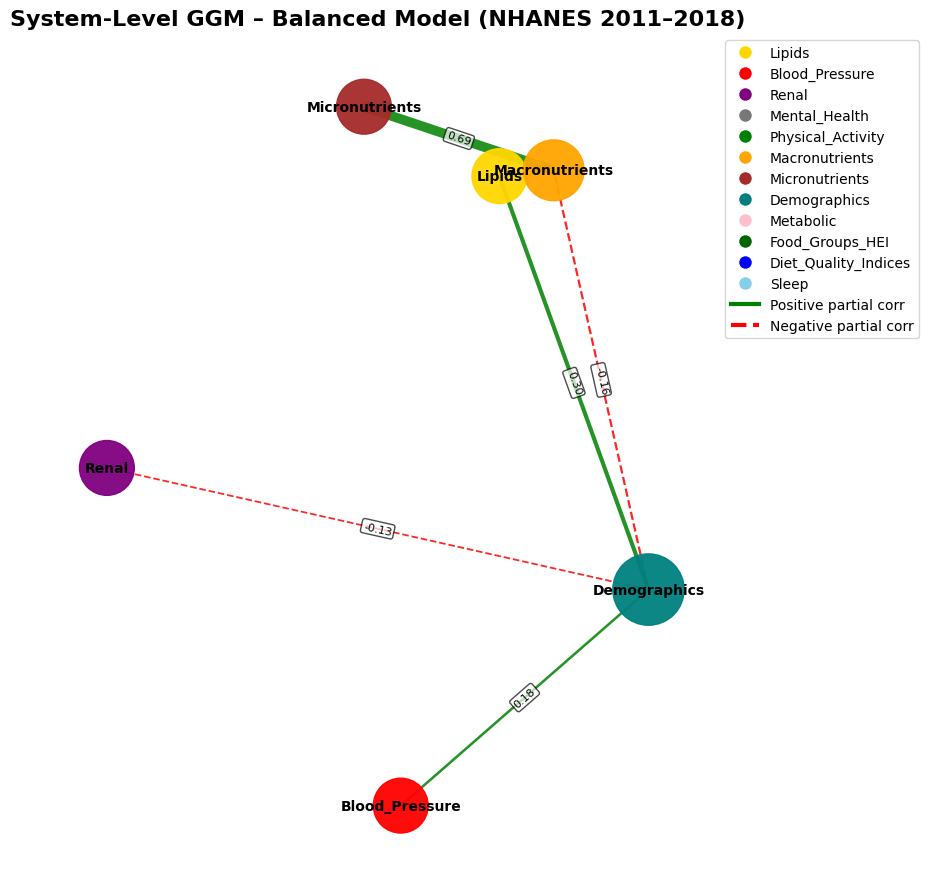

In [73]:
# Cell 6: Run system-level GGM and plot

# Define system color map
system_color_map = {
    "Lipids": "gold",
    "Blood_Pressure": "red",
    "Renal": "purple",
    "Mental_Health": "#777777",
    "Physical_Activity": "green",
    "Macronutrients": "orange",
    "Micronutrients": "brown",
    "Demographics": "teal",
    "Metabolic": "pink",
    "Food_Groups_HEI": "darkgreen",
    "Diet_Quality_Indices": "blue",
    "Sleep": "skyblue",
}

# ---------------------------------------------
# IMPORTANT: Create new dict BEFORE modifying it
# ---------------------------------------------
physio_systems_ggm = physio_systems.copy()
physio_systems_ggm["Physical_Activity"] = ["pa_index"]   # <-- Now safe

# Run pipeline (using patched dict)
df_sys_scores, partial_mat, G_ggm, ggm_model, df_std = run_system_ggm_pipeline(
    df_all,
    physio_systems_ggm,     # <-- patched systems dictionary
    min_nonmissing=0.4,
    edge_threshold=0.10,
)

# Draw balanced system-level network
fig, ax = draw_system_ggm(
    G_ggm,
    title="System-Level GGM – Balanced Model (NHANES 2011–2018)",
    color_map=system_color_map,
    edge_threshold=0.10,
)

# Save
fig.savefig("system_level_ggm_balanced.png", dpi=300, bbox_inches="tight")
print("Saved: system_level_ggm_balanced.png")


# **Interpretation of the System-Level GGM (Balanced Model, NHANES 2011–2018)**

This Gaussian Graphical Model (GGM) summarizes **partial correlations between physiological systems**, each represented by an aggregated z-score of its component variables. Edges represent **direct associations** between systems after conditioning on all others.

### **Key Features of the Network**

* **Nodes** represent physiological systems (e.g., Lipids, Blood Pressure, Micronutrients).
* **Edges** represent **non-zero partial correlations** (|(ρ)| ≥ 0.10):

  * **Green solid edges:** positive partial correlations
  * **Red dashed edges:** negative partial correlations
* **Edge width** reflects the **magnitude** of the partial correlation.
* **Node size** reflects **degree centrality** (how interconnected a system is).

---

## **Major Findings**

### **1. Strong coupling between Macronutrients and Micronutrients**

* The **largest positive partial correlation** in the network (≈ **0.69**).
* Suggests that dietary macronutrient patterns (carbs, fat, protein) co-vary tightly with micronutrient density (vitamins, minerals) even after adjusting for all other systems.

### **2. Lipids form a bridge between dietary patterns and demographics**

* Lipids ↔ Micronutrients (**positive**)
* Lipids ↔ Macronutrients (**positive**)
* These connections imply a strong diet–lipid axis that remains robust after controlling for other systems.

### **3. Demographics are centrally connected**

* Linked to:

  * **Lipids (positive)**
  * **Macronutrients (negative)**
  * **Blood Pressure (positive)**
  * **Renal function (negative)**

Demographics (age, sex, income) emerge as a **core driver** of system-level dependencies.

### **4. Blood Pressure is moderately connected**

* BP ↔ Demographics (**positive**)
* No direct link to diet or lipids once controlling for all systems.

### **5. Renal system shows a negative association with Demographics**

* Likely reflecting **age-associated renal decline** or socioeconomic gradients.

---

## **Why Physical Activity is Absent**

Physical Activity was excluded because it did **not meet the minimum non-missingness threshold** in this balanced model.
Even after harmonization, **pa_index had ~53% completeness**, below the 70% threshold used for system inclusion.

As a result:

* The system is **excluded before model fitting**
* No node appears in the plot
* No edges involving PA can be estimated

This can be reintroduced later by:

* Lowering the threshold
* Using fewer harmonized PA variables
* Imputing PA (not recommended for system-level GGM)

---

## **Overall Interpretation**

The balanced GGM reveals a **core triad** of interconnected systems:

**Demographics ↔ Lipids ↔ Diet (Macro + Micro)**

These form the **structural backbone** of the physiological network in NHANES.
Blood Pressure and Renal systems show **secondary, demography-mediated connections**.

The model reflects **stable physiology-level dependencies** robust to multivariable conditioning.

# simulate an individual patient for the innovations demo

In [74]:
physio_systems_ggm = {
    "Lipids": [
        "hdl", "tc", "tg", "ldl", "apob_est"
    ],
    "Metabolic": [
        "glucose", "insulin", "homa_ir"
    ],
    "Blood_Pressure": [
        "sbp", "dbp", "pulse_pressure"
    ],
    "Renal": [
        "creat_mg_dl", "egfr", "acr"
    ],
    "Sleep": [
        "sleep_hours", "sleep_trouble"
    ],
    "Mental_Health": [
        "phq9"
    ],
    "Physical_Activity": [
        "pa_vigorous_days", "pa_moderate_days",
        "pa_walk_days", "pa_index"
    ],
    "Diet": [
        "rpdqs", "rpdqs_norm",
        "whole_grains", "refined_grains", "nuts_seeds",
        "legumes", "low_fat_dairy", "fish", "red_meat",
        "processed_meat", "other_fruit",
        "citrus_melons_berries", "dark_green_veg",
        "other_veg", "ssb", "fried_foods"
    ],
    "Demographics": [
        "age", "pir"
    ]
}


In [75]:
df_h = df_all.copy()

df_h = harmonize_demographics(df_h)
df_h = harmonize_lipids(df_h)
df_h = harmonize_metabolic(df_h)
df_h = harmonize_bp(df_h)
df_h = harmonize_renal(df_h)
df_h = harmonize_sleep(df_h)
df_h = harmonize_phq(df_h)
df_h = harmonize_physical_activity_days(df_h)
df_h = harmonize_diet(df_h)

print("Harmonized columns present:")
print([c for c in df_h.columns if c not in df_all.columns])


Harmonized columns present:
['age', 'sex', 'race_ethnicity', 'pir', 'hdl', 'tc', 'tg', 'ldl', 'apob_est', 'glucose', 'insulin', 'homa_ir', 'sbp', 'dbp', 'pulse_pressure', 'creat_mg_dl', 'egfr', 'acr', 'sleep_hours', 'sleep_trouble', 'phq9', 'pa_vigorous_days', 'pa_moderate_days', 'pa_walk_days', 'pa_index', 'whole_grains', 'refined_grains', 'nuts_seeds', 'legumes', 'low_fat_dairy', 'fish', 'red_meat', 'processed_meat', 'other_fruit', 'citrus_melons_berries', 'dark_green_veg', 'other_veg', 'ssb', 'fried_foods']


In [76]:
vars_for_graph = sum(physio_systems_ggm.values(), [])
vars_for_graph = [v for v in vars_for_graph if v in df_h.columns]

print("Variables included:", vars_for_graph)



Variables included: ['hdl', 'tc', 'tg', 'ldl', 'apob_est', 'glucose', 'insulin', 'homa_ir', 'sbp', 'dbp', 'pulse_pressure', 'creat_mg_dl', 'egfr', 'acr', 'sleep_hours', 'sleep_trouble', 'phq9', 'pa_vigorous_days', 'pa_moderate_days', 'pa_walk_days', 'pa_index', 'whole_grains', 'refined_grains', 'nuts_seeds', 'legumes', 'low_fat_dairy', 'fish', 'red_meat', 'processed_meat', 'other_fruit', 'citrus_melons_berries', 'dark_green_veg', 'other_veg', 'ssb', 'fried_foods', 'age', 'pir']


In [77]:
df_desc = df_h[vars_for_graph].describe()
mu = df_desc.loc['mean']
sd = df_desc.loc['std']


In [78]:
patient = mu.copy()

z_overrides = {
    "apob_est": +2.0,
    "hdl": -1.8,
    "tg": +2.5,

    "glucose": +2.0,
    "insulin": +2.0,
    "homa_ir": +2.5,

    "sbp": +1.5,
    "dbp": +1.0,

    "sleep_hours": -1.5,
    "sleep_trouble": +1.0,

    "phq9": +2.0,
    "pa_index": -2.5,

    "rpdqs_norm": -1.0 if "rpdqs_norm" in df_h.columns else None,

    "age": +1.0,
    "pir": -1.0,

    "egfr": +0.5,
    "acr": +1.0
}

for var, z in z_overrides.items():
    if var in patient.index:
        patient[var] = mu[var] + z * sd[var]

example_patient = patient


In [79]:
z_scores = (example_patient - mu) / sd
z_scores = z_scores.fillna(0)


In [80]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def plot_patient_network(
    G,
    z_scores,
    title="Biovista Individual Network (Simulated)",
    out_file="biovista_patient_network.png"
):
    Gp = G.copy()

    # attach z-scores
    for n in Gp.nodes():
        Gp.nodes[n]['z'] = float(z_scores.get(n, 0.0))

    # layout: re-use GGM layout if available
    pos = nx.spring_layout(Gp, seed=1, k=0.45)

    z_vals = np.array([Gp.nodes[n].get("z", 0.0) for n in Gp.nodes()])
    z_clipped = np.clip(z_vals, -3, 3)

    cmap = plt.cm.coolwarm
    node_colors = cmap((z_clipped + 3) / 6)
    node_sizes = 350 + 600 * np.abs(z_clipped)

    edge_widths = [
        0.6 + 3.0 * abs(d.get("weight", 0.05))
        for (_, _, d) in Gp.edges(data=True)
    ]

    fig, ax = plt.subplots(figsize=(12, 12))

    nx.draw_networkx_edges(Gp, pos, width=edge_widths, alpha=0.25, ax=ax)
    nx.draw_networkx_nodes(
        Gp, pos,
        node_color=node_colors,
        node_size=node_sizes,
        edgecolors="black",
        linewidths=0.8,
        ax=ax
    )
    nx.draw_networkx_labels(Gp, pos, font_size=7, font_weight="bold", ax=ax)

    sm = plt.cm.ScalarMappable(
        cmap=cmap,
        norm=plt.Normalize(vmin=-3, vmax=3)
    )
    sm.set_array([])
    plt.colorbar(sm, ax=ax, shrink=0.7).set_label("Z-score")

    ax.set_title(title)
    ax.axis("off")
    plt.tight_layout()
    plt.savefig(out_file, dpi=350)
    plt.show()


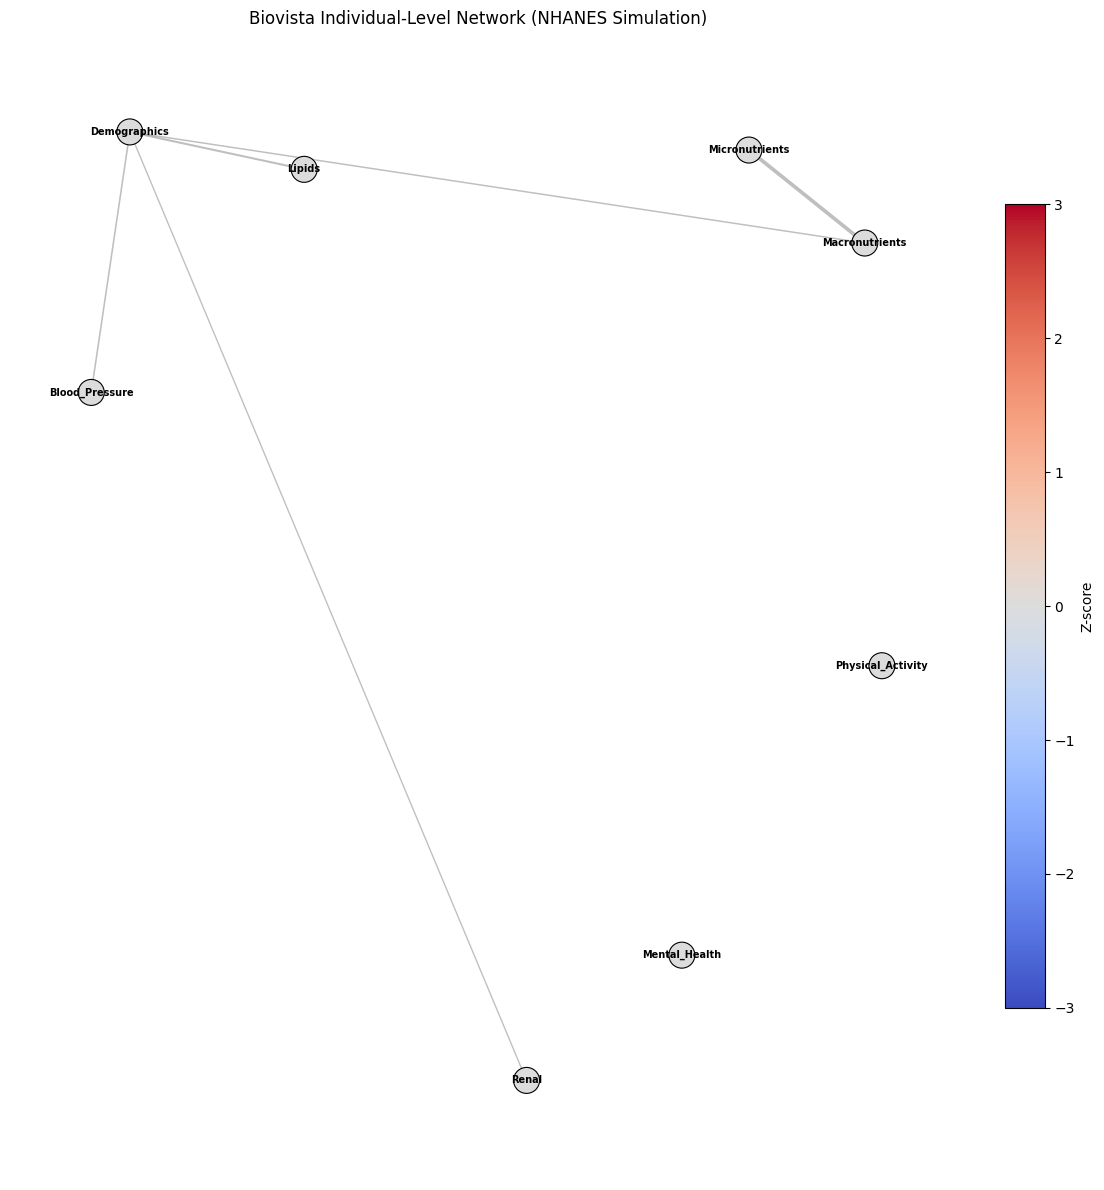

In [81]:
plot_patient_network(
    G_ggm,
    z_scores,
    title="Biovista Individual-Level Network (NHANES Simulation)",
    out_file="biovista_patient_network.png"
)

In [82]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import GraphicalLasso

# -------------------------------------------------------
# UPDATED SYSTEM → VARIABLE MAP
# (Your original + added high-coverage biomarkers)
# -------------------------------------------------------
physio_systems_ggm = {
    "Demographics": ["age", "pir"],

    "Lipids": ["hdl", "tc", "tg", "ldl", "apob_est"],

    "Metabolic": [
        "glucose", "insulin", "homa_ir",
        "bmi", "waist"
    ],

    "Blood_Pressure": ["sbp", "dbp", "pulse_pressure"],

    "Renal": ["creat_mg_dl", "egfr", "acr"],

    "Liver": ["alt", "ast"],

    "Inflammation": ["crp", "wbc"],

    "Hematologic": ["hemoglobin", "platelets"],

    "Sleep": ["sleep_hours", "sleep_trouble"],

    "Mental_Health": ["phq9"],

    "Physical_Activity": [
        "pa_vigorous_days", "pa_moderate_days",
        "pa_walk_days", "pa_index"
    ],

    "Diet": [
        "whole_grains", "refined_grains", "nuts_seeds", "legumes",
        "low_fat_dairy", "fish", "red_meat", "processed_meat",
        "other_fruit", "citrus_melons_berries", "dark_green_veg",
        "other_veg", "ssb", "fried_foods"
    ],
}

# -------------------------------------------------------
# FLATTEN AND FILTER BY MISSINGNESS ≥ 40%
# -------------------------------------------------------
all_vars = sum(physio_systems_ggm.values(), [])
all_vars = [v for v in all_vars if v in df_h.columns]

nonmissing_frac = df_h[all_vars].notna().mean()
vars_use = nonmissing_frac[nonmissing_frac >= 0.40].index.tolist()

print("Variables used in variable-level GGM:", len(vars_use))
print(vars_use)


# -------------------------------------------------------
# 2. IMPUTE + STANDARDIZE
# -------------------------------------------------------
X = df_h[vars_use].to_numpy(float)

imputer = KNNImputer(n_neighbors=5)
X_imp = imputer.fit_transform(X)

scaler = StandardScaler()
X_std = scaler.fit_transform(X_imp)

# -------------------------------------------------------
# 3. FIT GRAPHICAL LASSO
# -------------------------------------------------------
ggm_model = GraphicalLasso(alpha=0.15, max_iter=200)
ggm_model.fit(X_std)

precision = ggm_model.precision_.copy()

# Partial correlations
diag = np.sqrt(np.diag(precision))
outer = np.outer(diag, diag)
partial_corr = -precision / outer
np.fill_diagonal(partial_corr, 0.0)

# -------------------------------------------------------
# 4. BUILD NETWORKX GRAPH
# -------------------------------------------------------
G_var = nx.Graph()

# System membership lookup
var_to_system = {}
for system, var_list in physio_systems_ggm.items():
    for v in var_list:
        if v in vars_use:
            var_to_system[v] = system

# Add nodes
for v in vars_use:
    G_var.add_node(v, system=var_to_system.get(v, "Other"))

# Add edges (threshold = 0.10)
edge_threshold = 0.10
for i, vi in enumerate(vars_use):
    for j in range(i + 1, len(vars_use)):
        vj = vars_use[j]
        w = partial_corr[i, j]
        if abs(w) >= edge_threshold:
            G_var.add_edge(vi, vj, weight=w)

print(f"Variable-level GGM: {G_var.number_of_nodes()} nodes, {G_var.number_of_edges()} edges")

# -------------------------------------------------------
# 5. CONSISTENT LAYOUT
# -------------------------------------------------------
pos_var = nx.spring_layout(G_var, seed=1, k=0.35)


Variables used in variable-level GGM: 15
['age', 'pir', 'hdl', 'tc', 'sbp', 'dbp', 'pulse_pressure', 'creat_mg_dl', 'egfr', 'acr', 'phq9', 'pa_vigorous_days', 'pa_moderate_days', 'pa_walk_days', 'pa_index']
Variable-level GGM: 15 nodes, 9 edges


In [83]:
# -------------------------------------------------------
# 5. Population mean & SD for these variables
# -------------------------------------------------------
df_desc = df_h[vars_use].describe()
mu = df_desc.loc["mean"]
sd = df_desc.loc["std"]

# Start at mean
patient_vals = mu.copy()

# Make an "interesting" patient (abnormal in several systems)
z_overrides = {
    # Lipids / metabolic
    "apob_est": +2.0,
    "hdl": -1.5,
    "tg": +2.0,
    "glucose": +2.0,
    "insulin": +2.0,
    "homa_ir": +2.5,

    # BP
    "sbp": +1.5,
    "dbp": +1.0,

    # Renal
    "egfr": +0.5,
    "acr": +1.0,

    # Sleep / mental health
    "sleep_hours": -1.5,
    "sleep_trouble": +1.5,
    "phq9": +2.0,

    # Physical activity
    "pa_index": -2.0,

    # Diet (if present)
    "whole_grains": -1.0,
    "red_meat": +1.5,
    "ssb": +2.0,

    # Demographics
    "age": +1.0,
    "pir": -1.0
}

for var, z in z_overrides.items():
    if var in patient_vals.index:
        patient_vals[var] = mu[var] + z * sd[var]

# Variable-level z-scores for this patient
z_patient = (patient_vals - mu) / sd
z_patient = z_patient.fillna(0.0)


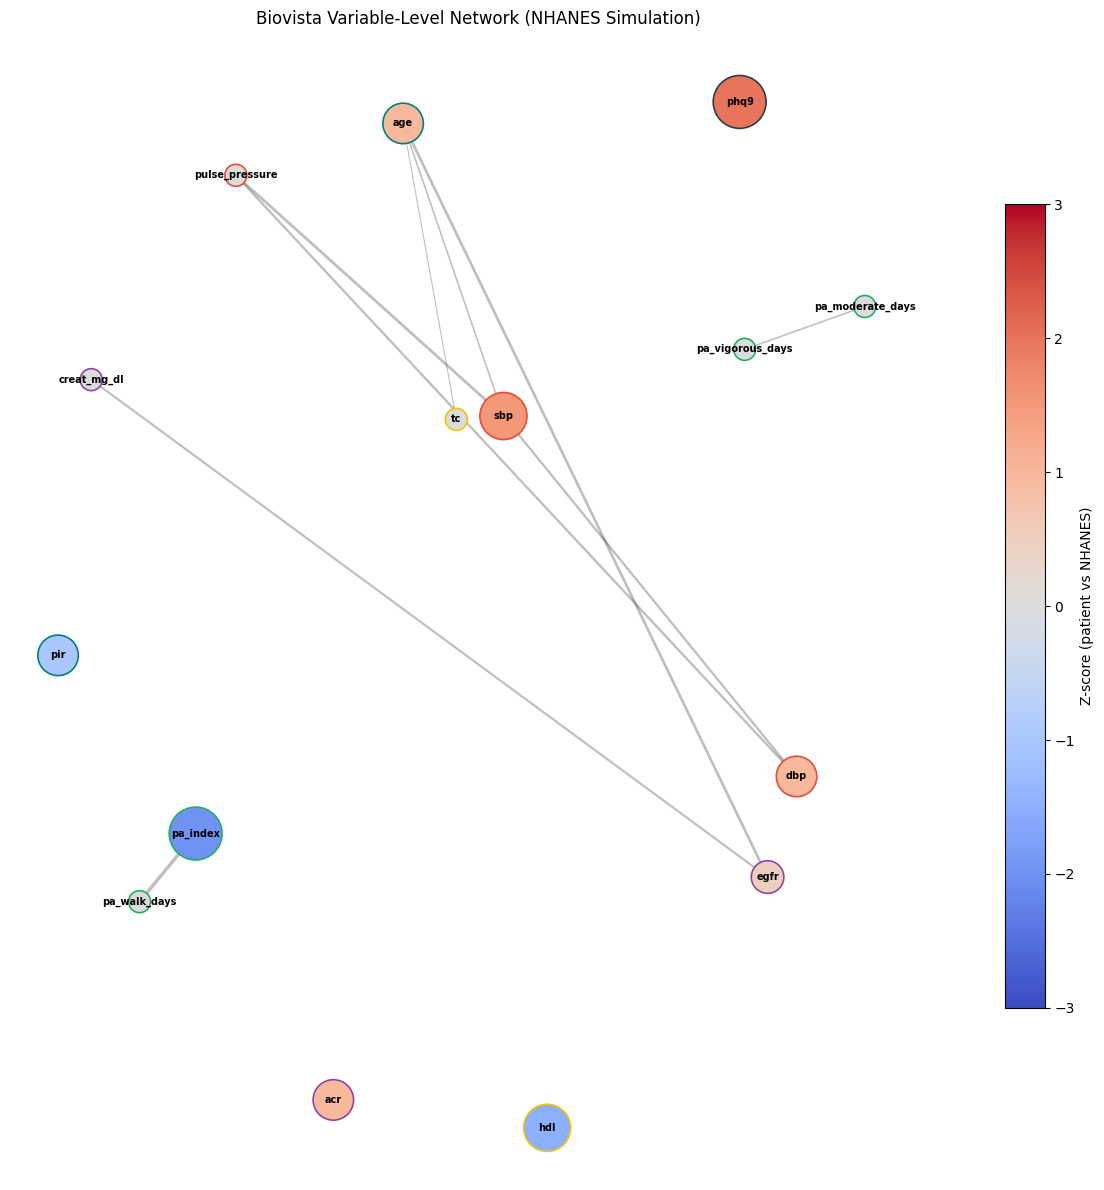

Saved: biovista_variable_patient_network.png


In [84]:
# -------------------------------------------------------
# 6. Pretty plotting function (variable-level Biovista)
# -------------------------------------------------------
system_color_map = {
    "Demographics": "#008080",
    "Lipids": "#f1c40f",
    "Metabolic": "#e67e22",
    "Blood_Pressure": "#e74c3c",
    "Renal": "#8e44ad",
    "Sleep": "#3498db",
    "Mental_Health": "#2c3e50",
    "Physical_Activity": "#27ae60",
    "Diet": "#16a085",
    "Other": "#7f8c8d",
}

def plot_biovista_patient_network(
    G,
    z_scores,
    var_to_system,
    pos,
    title="Biovista Variable-Level Network (NHANES Simulation)",
    out_file="biovista_variable_patient_network.png"
):
    # Collect z-scores in graph
    for n in G.nodes():
        G.nodes[n]["z"] = float(z_scores.get(n, 0.0))
        G.nodes[n]["system"] = var_to_system.get(n, "Other")

    z_vals = np.array([G.nodes[n]["z"] for n in G.nodes()])
    z_clipped = np.clip(z_vals, -3, 3)

    # Color by z-score
    cmap = plt.cm.coolwarm
    node_colors = cmap((z_clipped + 3) / 6)

    # Size by |z|
    node_sizes = 250 + 600 * np.abs(z_clipped)

    # Edge widths by |weight|
    edge_widths = [
        0.4 + 3.0 * abs(d.get("weight", 0.05))
        for (_, _, d) in G.edges(data=True)
    ]

    # Node outlines by system
    node_edgecolors = [
        system_color_map.get(G.nodes[n]["system"], "#7f8c8d")
        for n in G.nodes()
    ]

    fig, ax = plt.subplots(figsize=(12, 12))

    nx.draw_networkx_edges(
        G, pos,
        width=edge_widths,
        alpha=0.25,
        ax=ax
    )

    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,
        node_size=node_sizes,
        edgecolors=node_edgecolors,
        linewidths=1.2,
        ax=ax
    )

    nx.draw_networkx_labels(
        G, pos,
        font_size=7,
        font_weight="bold",
        ax=ax
    )

    # Colorbar for z-score
    sm = plt.cm.ScalarMappable(
        cmap=cmap, norm=plt.Normalize(vmin=-3, vmax=3)
    )
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
    cbar.set_label("Z-score (patient vs NHANES)")

    ax.set_title(title)
    ax.axis("off")
    plt.tight_layout()
    fig.savefig(out_file, dpi=350, bbox_inches="tight")
    plt.show()

    return fig, ax

# -------------------------------------------------------
# 7. Generate and save the figure
# -------------------------------------------------------
fig, ax = plot_biovista_patient_network(
    G_var,
    z_patient,
    var_to_system,
    pos_var,
    title="Biovista Variable-Level Network (NHANES Simulation)",
    out_file="biovista_variable_patient_network.png"
)
print("Saved: biovista_variable_patient_network.png")


In [85]:
# -----------------------------
# Additional High-Coverage Biomarkers
# -----------------------------
def harmonize_additional(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # BMI
    if "BMXBMI" in out.columns:
        out["bmi"] = out["BMXBMI"]
    else:
        out["bmi"] = np.nan

    # Waist circumference
    if "BMXWAIST" in out.columns:
        out["waist"] = out["BMXWAIST"]
    else:
        out["waist"] = np.nan

    # ALT (Alanine aminotransferase)
    if "LBXALT" in out.columns:
        out["alt"] = out["LBXALT"]
    elif "LBDALTSI" in out.columns:
        out["alt"] = out["LBDALTSI"]
    else:
        out["alt"] = np.nan

    # AST (Aspartate aminotransferase)
    if "LBXAST" in out.columns:
        out["ast"] = out["LBXAST"]
    elif "LBDASSI" in out.columns:
        out["ast"] = out["LBDASSI"]
    else:
        out["ast"] = np.nan

    # CRP (C-Reactive Protein)
    if "LBXCRP" in out.columns:
        out["crp"] = out["LBXCRP"]
    elif "LBDCRPSI" in out.columns:
        out["crp"] = out["LBDCRPSI"]
    else:
        out["crp"] = np.nan

    # Hemoglobin
    if "LBXHGB" in out.columns:
        out["hemoglobin"] = out["LBXHGB"]
    else:
        out["hemoglobin"] = np.nan

    # White Blood Cell Count
    if "LBXWBCSI" in out.columns:
        out["wbc"] = out["LBXWBCSI"]
    elif "LBXWBC" in out.columns:
        out["wbc"] = out["LBXWBC"]
    else:
        out["wbc"] = np.nan

    # Platelets
    if "LBXPLTSI" in out.columns:
        out["platelets"] = out["LBXPLTSI"]
    elif "LBXPLT" in out.columns:
        out["platelets"] = out["LBXPLT"]
    else:
        out["platelets"] = np.nan

    return out


In [86]:
df_h = harmonize_additional(df_h)


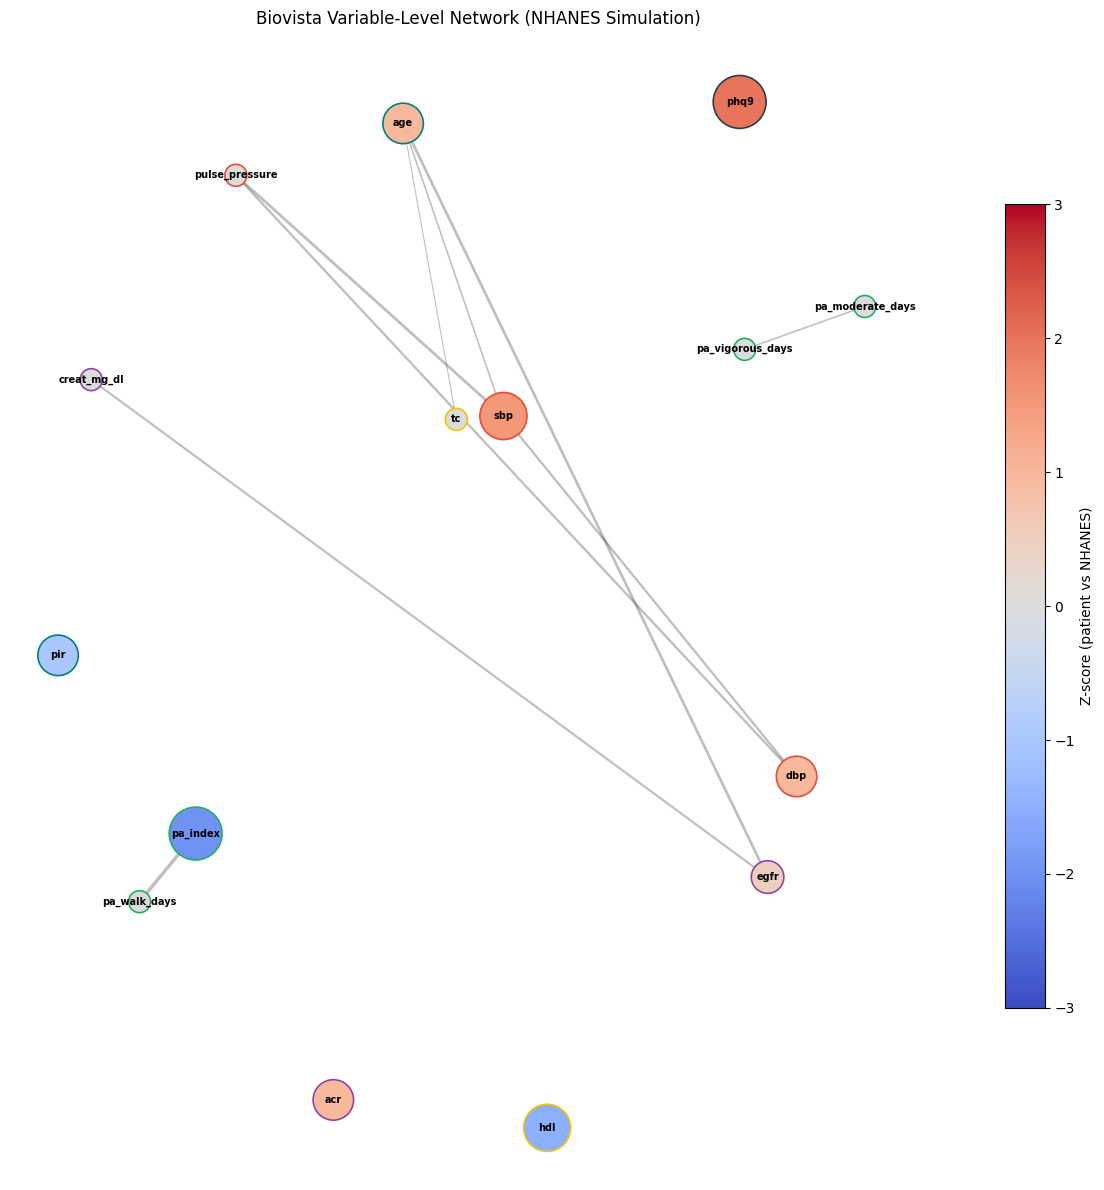

Saved: biovista_variable_patient_network.png


In [87]:
# -------------------------------------------------------
# Pretty plotting function (variable-level Biovista)
# -------------------------------------------------------
system_color_map = {
    "Demographics": "#008080",
    "Lipids": "#f1c40f",
    "Metabolic": "#e67e22",
    "Blood_Pressure": "#e74c3c",
    "Renal": "#8e44ad",
    "Sleep": "#3498db",
    "Mental_Health": "#2c3e50",
    "Physical_Activity": "#27ae60",
    "Diet": "#16a085",
    "Other": "#7f8c8d",
}

def plot_biovista_patient_network(
    G,
    z_scores,
    var_to_system,
    pos,
    title="Biovista Variable-Level Network (NHANES Simulation)",
    out_file="biovista_variable_patient_network.png"
):
    # Collect z-scores in graph
    for n in G.nodes():
        G.nodes[n]["z"] = float(z_scores.get(n, 0.0))
        G.nodes[n]["system"] = var_to_system.get(n, "Other")

    z_vals = np.array([G.nodes[n]["z"] for n in G.nodes()])
    z_clipped = np.clip(z_vals, -3, 3)

    # Color by z-score
    cmap = plt.cm.coolwarm
    node_colors = cmap((z_clipped + 3) / 6)

    # Size by |z|
    node_sizes = 250 + 600 * np.abs(z_clipped)

    # Edge widths by |weight|
    edge_widths = [
        0.4 + 3.0 * abs(d.get("weight", 0.05))
        for (_, _, d) in G.edges(data=True)
    ]

    # Node outlines by system
    node_edgecolors = [
        system_color_map.get(G.nodes[n]["system"], "#7f8c8d")
        for n in G.nodes()
    ]

    fig, ax = plt.subplots(figsize=(12, 12))

    nx.draw_networkx_edges(
        G, pos,
        width=edge_widths,
        alpha=0.25,
        ax=ax
    )

    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,
        node_size=node_sizes,
        edgecolors=node_edgecolors,
        linewidths=1.2,
        ax=ax
    )

    nx.draw_networkx_labels(
        G, pos,
        font_size=7,
        font_weight="bold",
        ax=ax
    )

    # Colorbar for z-score
    sm = plt.cm.ScalarMappable(
        cmap=cmap, norm=plt.Normalize(vmin=-3, vmax=3)
    )
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
    cbar.set_label("Z-score (patient vs NHANES)")

    ax.set_title(title)
    ax.axis("off")
    plt.tight_layout()
    fig.savefig(out_file, dpi=350, bbox_inches="tight")
    plt.show()

    return fig, ax

# -------------------------------------------------------
# 7. Generate and save the figure
# -------------------------------------------------------
fig, ax = plot_biovista_patient_network(
    G_var,
    z_patient,
    var_to_system,
    pos_var,
    title="Biovista Variable-Level Network (NHANES Simulation)",
    out_file="biovista_variable_patient_network.png"
)
print("Saved: biovista_variable_patient_network.png")


In [88]:
vars_to_check = [
    "bmi", "waist", "alt", "ast", "crp", "wbc",
    "hemoglobin", "platelets"
]

print(df_h[vars_to_check].notna().mean())


bmi           0.878997
waist         0.837139
alt           0.000000
ast           0.000000
crp           0.000000
wbc           0.820870
hemoglobin    0.820870
platelets     0.820845
dtype: float64
